# About 
A quick notebook to test how to
- get data from AWS DynamoDB (using aws boto python library)
- clean up data with *Pandas*
- plot data with the specificities of time series (automatic time scalling)



# Prerequisites

## Install AWS CLI
Allows boto library to use the CLI credentials to authenticate.

## Install boto lib
pip install boto3


# Retrieve data from dynamoDB

## Connect with boto3

In [8]:
from boto3 import resource
from boto3.dynamodb.conditions import Key

# The boto3 dynamoDB resource
dynamodb_resource = resource('dynamodb')

my_table_name = 'iot_data2'
table = dynamodb_resource.Table(my_table_name)

## Get table metadata

In [9]:
def get_table_metadata(table_name):
    """
    Get some metadata about chosen table.
    """
    table = dynamodb_resource.Table(table_name)

    return {
        'num_items': table.item_count,
        'primary_key_name': table.key_schema[0],
        'status': table.table_status,
        'bytes_size': table.table_size_bytes,
        'global_secondary_indices': table.global_secondary_indexes
    }

# Get data from our table
my_table_name = 'iot_data2'
table_metadata = get_table_metadata(my_table_name)
print table_metadata
print "number of entries:", table_metadata['num_items']

{'status': u'ACTIVE', 'primary_key_name': {u'KeyType': u'HASH', u'AttributeName': u'deviceid'}, 'num_items': 252, 'bytes_size': 33137, 'global_secondary_indices': None}
number of entries: 252


### Apparté: dicts

In [1]:
import json
jsonData = '{"name":"myRaspberry", "color":"red", "id":42}'
jsonToPython = json.loads(jsonData)
print jsonToPython["name"]


myRaspberry


## Query and scan table

*Code originally shared by Martina Pugliese (https://martinapugliese.github.io/interacting-with-a-dynamodb-via-boto3/). Thank you !*


In [11]:
def scan_table(table_name, filter_key=None, filter_value=None):
    """
    Perform a scan operation on table.
    Can specify filter_key (col name) and its value to be filtered.
    """
    table = dynamodb_resource.Table(table_name)

    if filter_key and filter_value:
        filtering_exp = Key(filter_key).eq(filter_value)
        response = table.scan(FilterExpression=filtering_exp)
    else:
        response = table.scan()

    return response


def query_table(table_name, filter_key=None, filter_value=None):
    """
    Perform a query operation on the table. 
    Can specify filter_key (col name) and its value to be filtered.
    """
    table = dynamodb_resource.Table(table_name)

    if filter_key and filter_value:
        filtering_exp = Key(filter_key).eq(filter_value)
        response = table.query(KeyConditionExpression=filtering_exp)
    else:
        response = table.query()

    return response


In [12]:
full_scan = scan_table(my_table_name)

# Uncomment next line to see the raw data fetched
print full_scan

#jsonified_full_scan = json.load(full_scan)
#print(json.dumps(jsonified_full_scan, indent=2))

{u'Count': 262, u'Items': [{u'timestamp': u'1528731454.09', u'data': {u'timestamp': u'1528731454.09', u'device_id': u'olivepi', u'temperature': u'44.5', u'comments': u'dummy value', u'sequence': Decimal('25')}, u'deviceid': u'olivepi'}, {u'timestamp': u'1528731460.23', u'data': {u'timestamp': u'1528731460.23', u'device_id': u'olivepi', u'temperature': u'44.5', u'comments': u'dummy value', u'sequence': Decimal('26')}, u'deviceid': u'olivepi'}, {u'timestamp': u'1528731466.37', u'data': {u'timestamp': u'1528731466.37', u'device_id': u'olivepi', u'temperature': u'44.0', u'comments': u'dummy value', u'sequence': Decimal('27')}, u'deviceid': u'olivepi'}, {u'timestamp': u'1528731472.55', u'data': {u'timestamp': u'1528731472.55', u'device_id': u'olivepi', u'temperature': u'45.1', u'comments': u'dummy value', u'sequence': Decimal('28')}, u'deviceid': u'olivepi'}, {u'timestamp': u'1528731478.69', u'data': {u'timestamp': u'1528731478.69', u'device_id': u'olivepi', u'temperature': u'45.1', u'comme

### Iterate results and transform into series

In [13]:
timestamps = []
temperatures = []

for data_point in full_scan['Items']:
    ts = data_point['data']['timestamp']
    measure = data_point['data']['temperature']
    #print ts, measure
    timestamps.append(ts)
    temperatures.append(measure)

# Clean up data with Pandas

## Create a dataframe 

In [14]:
import pandas as pd

dat = pd.DataFrame({"temp": temperatures,"ts": timestamps})

# Check the 5 first entries
dat.head(5)

,temp,ts
0,44.5,1528731454.09
1,44.5,1528731460.23
2,44.0,1528731466.37
3,45.1,1528731472.55
4,45.1,1528731478.69


## Force the typing of data
We need to make sure that timestamps values are typed into dates. This will ease later plotting (
e.g. graphics are scalled properly on time axis).

In [15]:
# Pandas can show the types of DataFrame series
# by default it returns untyped object!
dat.dtypes

temp    object
ts      object
dtype: object

In [16]:
# Option 1: Convert using standard functions:
from datetime import datetime

utc_dates = map(datetime.fromtimestamp, map(float,dat['ts']))


In [17]:

# Option 2: Convert using pandas
dat['ts'] = pd.to_datetime(dat['ts'], unit='s')
dat.dtypes




temp            object
ts      datetime64[ns]
dtype: object

In [18]:
# Option 2: Convert using pandas
dat['temp'] = pd.to_numeric(dat['temp'])
dat.dtypes

temp           float64
ts      datetime64[ns]
dtype: object

## Basic stats

Basic statistics to ensure that data is interpreted properly.

In [19]:
dat['temp'].mean()

43.350167263088515

In [20]:
dat['temp'].max()

45.1

In [21]:
dat['temp'].min()

21.893106491222763

In [22]:
# All in one
dat.describe()

,temp
count,262.000000
mean,43.350167
std,4.081001
min,21.893106
25%,44.000000
50%,44.000000
75%,44.500000
max,45.100000


# Plot results

## Display the raw serie with pyplot
We are printing raw data just to quick ceck the values. Time representation is wrong.

In [23]:
from matplotlib import pyplot
pyplot.plot(dat['temp'])

## Display with matplotlib (time scalling comes for free)

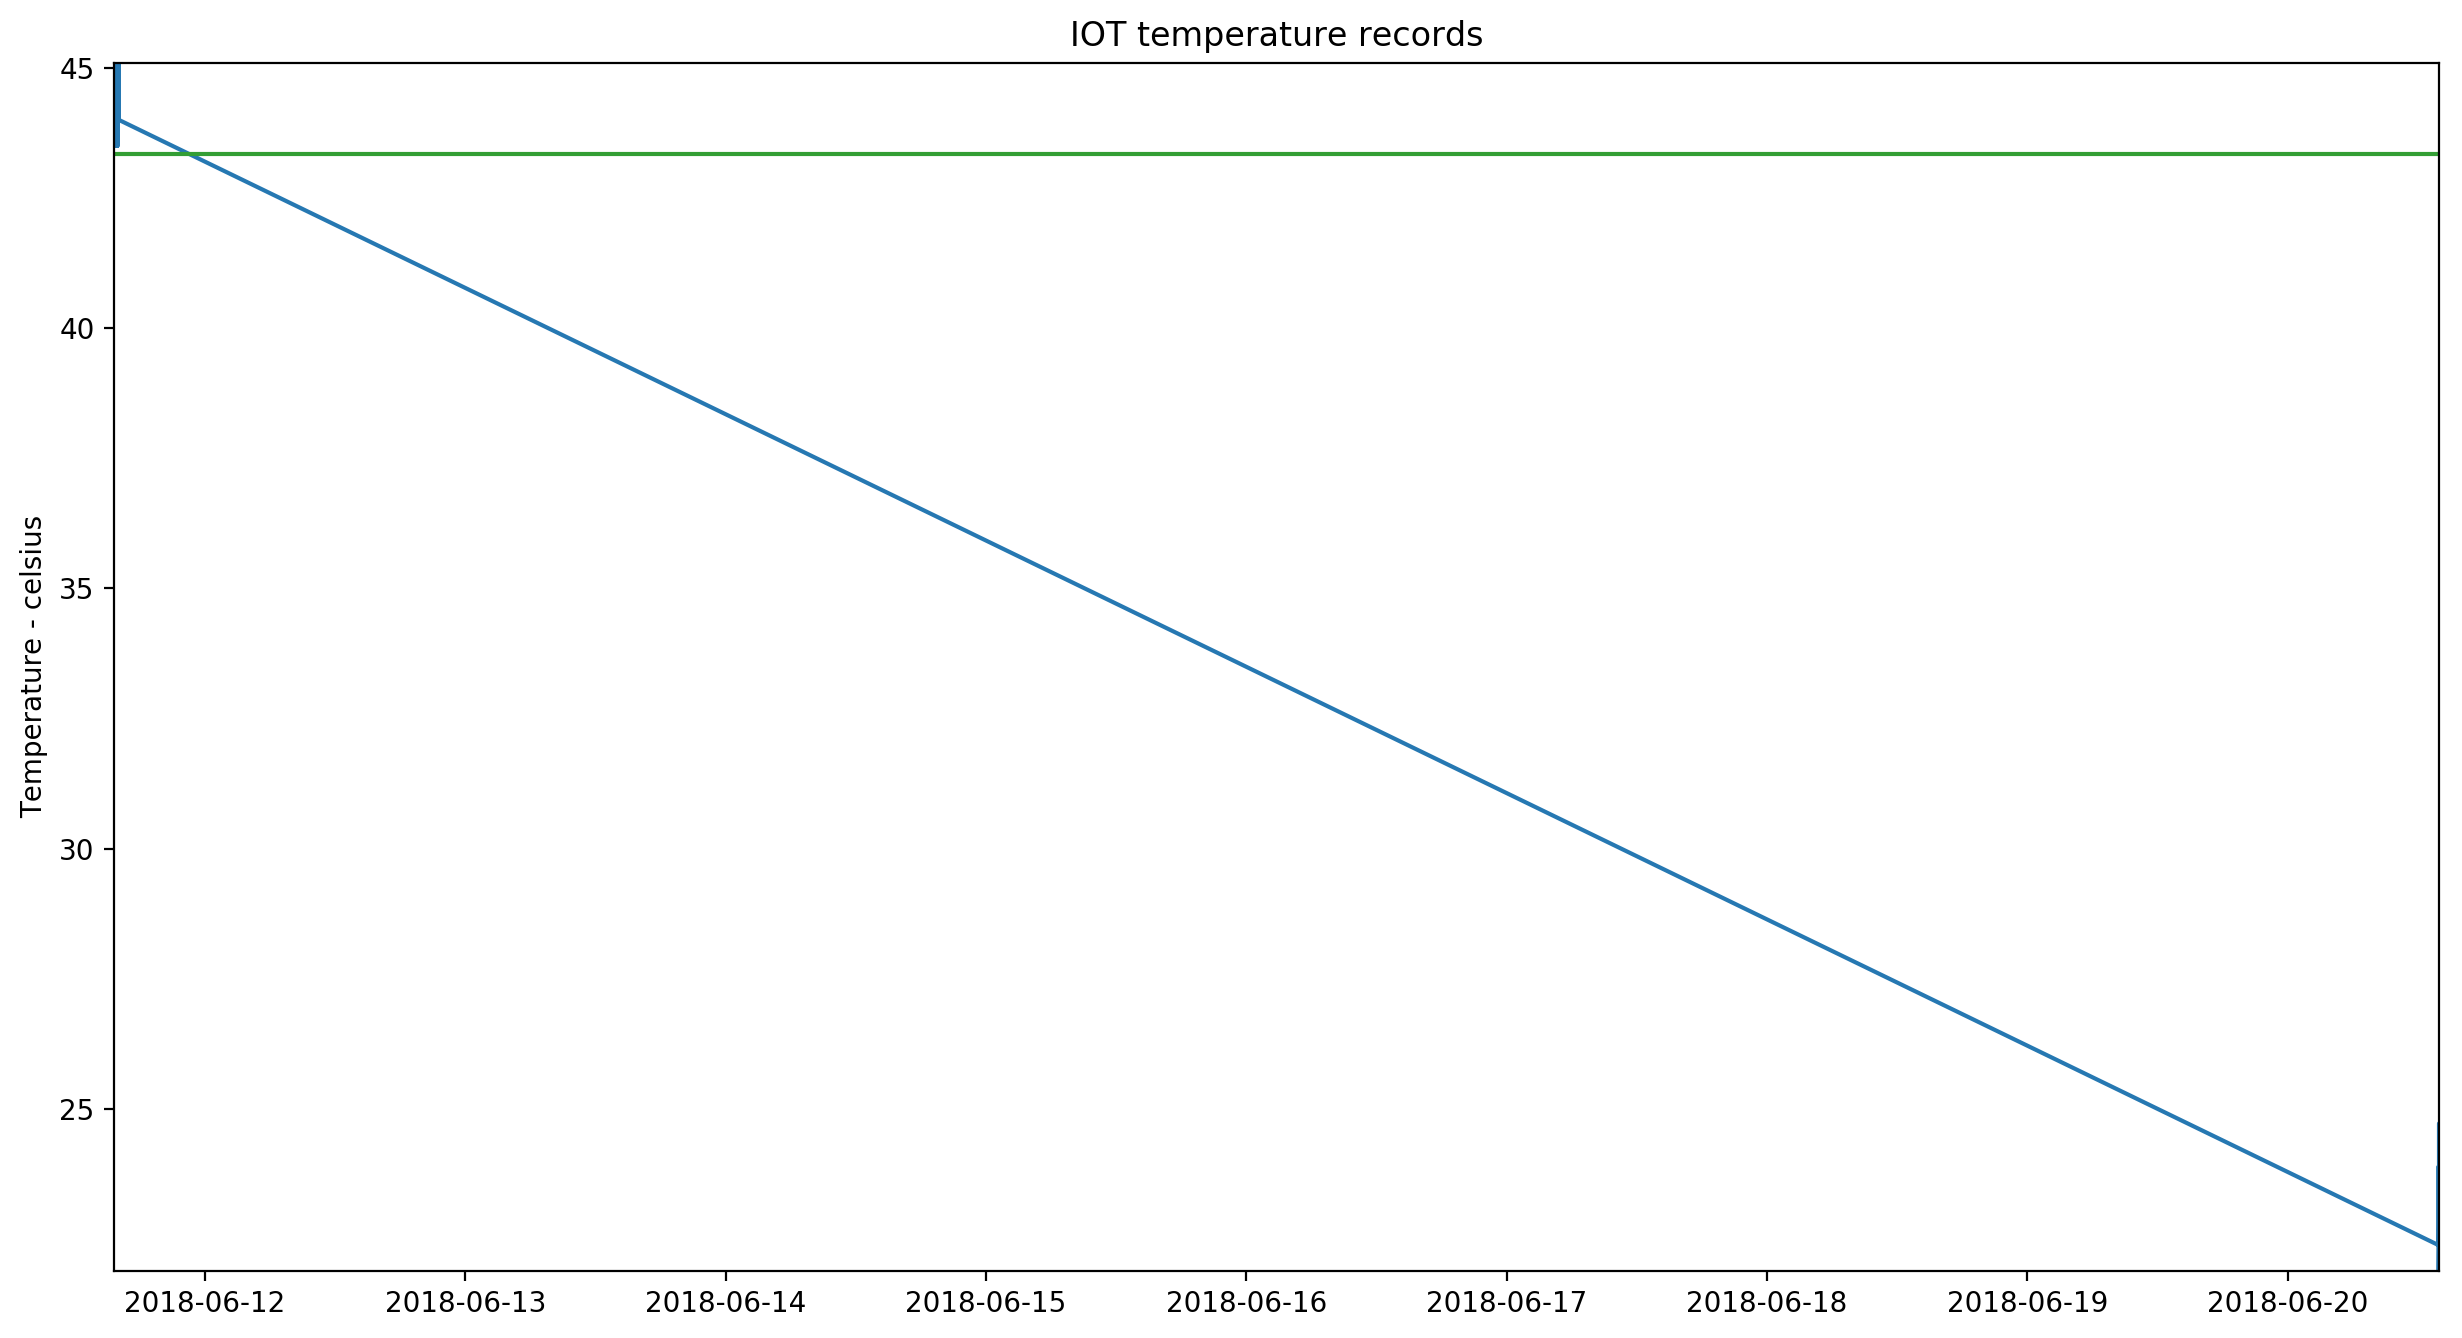

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


colors = ['#2678B2', '#AFC8E7', '#FD7F28', '#FDBB7D', 
          '#339E34', '#9ADE8D', '#D42A2F', '#FD9898', 
          '#9369BB', '#C5B1D4', '#8B564C', '#C39C95', 
          '#E179C1', '#F6B7D2', '#7F7F7F', '#C7C7C7']


# Define plot
fig, ax = plt.subplots(figsize=(15, 8), dpi=200)
ax.plot(dat['ts'], dat['temp'], c=colors[0])

# Add mean line
ax.plot((dat['ts'].min(), dat['ts'].max()), (dat['temp'].mean(), dat['temp'].mean()), c=colors[4])


# Optional manage orientation of dates values on x axis
#fig.autofmt_xdate()

# Presentation
plt.title('IOT temperature records')
plt.ylabel('Temperature - celsius')
plt.margins(0)

plt.show()

# References

DynamoDB
- https://martinapugliese.github.io/interacting-with-a-dynamodb-via-boto3/

Plot
- https://blog.webkid.io/analysing-data-with-jupyter-notebooks-and-pandas/


Python basics:
- https://openclassrooms.com/courses/apprenez-a-programmer-en-python/les-dictionnaires-2
- https://openclassrooms.com/courses/apprenez-a-programmer-en-python/les-listes-et-tuples-2-2
- https://code.tutsplus.com/tutorials/how-to-work-with-json-data-using-python--cms-25758

